In [1]:
import os
import glob
import pathlib
import time
import math
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torchvision import utils as torchvision_utils
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
)

import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing

- Each image is preprocessed specifically for the EfficientNetB0 model. Every image is resized to 256 x 256 pixels and normalized using the mean and standard deviation appropriate for EfficientNetB0.

- The images are categorized into four classes, with each class having its separate folder within the dataset.

- The dataset is split into training (80%), validation (10%), and test (10%) sets using PyTorch's `random_split` helper function, ensuring random and proportional division for each class.

In [3]:
def prepare_data(data_path):
    """
    Function to prepare data for training by applying transformations and splitting into train, validation, and test sets.

    Parameters:
    - data_path: a string representing the path to the data

    Returns:
    - train_data: the training dataset
    - val_data: the validation dataset
    - test_data: the test dataset
    """
    transform = v2.Compose([
        v2.Resize(256),   #must same as here
        v2.CenterCrop(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
    ])
    dataset = ImageFolder(root=data_path, transform=transform)
    total_size = len(dataset)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size
    train_data, val_data, test_data = random_split(
        dataset, [train_size, val_size, test_size]
    )
    return train_data, val_data, test_data


def load_data(train_data, val_data, test_data, batch_size):
    """
    Load the given train, validation, and test data into data loaders with the specified batch size.

    Parameters:
        train_data (Dataset): The dataset containing the training data.
        val_data (Dataset): The dataset containing the validation data.
        test_data (Dataset): The dataset containing the test data.
        batch_size (int): The batch size for the data loaders.

    Returns:
        tuple: A tuple containing the train data loader, validation data loader, and test data loader.
    """
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader


def initialize_model(num_classes):
    """
    Initializes a EfficientNetB0 model with the specified number of classes.

    Parameters:
        num_classes (int): The number of classes for the model.

    Returns:
        torch.nn.Module: The initialized EfficientNetB0 model.
    """
    model = models.efficientnet_b0(weights=None, num_classes=num_classes)
    return model.to(DEVICE)


def show_transformed_images(dataset):
    """
    Generate a grid of transformed images and display them.

    Parameters:
    - dataset: The dataset containing the images to transform.

    Returns:
    None
    """
    loader = DataLoader(dataset, batch_size=12, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision_utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print("Labels:", labels)


## Hyperparameters:

- `LR`: Learning rate for the optimizer.
- `MOMENTUM`: Momentum factor for the SGD optimizer.
- `STEP_SIZE`: Number of epochs after which the learning rate is adjusted.
- `GAMMA`: Factor by which the learning rate is reduced.
- `NUM_CLASSES`: Number of classes in the classification task.
- `NUM_EPOCHES`: Number of epochs for training.
- `BATCH_SIZE`: Number of samples in each mini-batch for training.

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR = 0.001
MOMENTUM = 0.9
STEP_SIZE = 20
GAMMA = 0.1
NUM_CLASSES = 4
NUM_EPOCHS = 10
BATCH_SIZE = 32
DATA_PATH = "/kaggle/input/c19d-dataset-2/c19d-dataset"

## Model initialization:

EfficientNetB0 is initialized using random weights and available number of classes.

Defines the CrossEntropyLoss criterion for calculating the loss.

Initializes the SGD optimizer with the model parameters, learning rate, and momentum.

## Model Training:

The training loop iterates over a specified number of epochs, performing both evaluation and training on the training dataset.

### During training:

- The model is set to training mode using `model.train()`.
- The optimizer's gradients are zeroed using `optimizer.zero_grad()`.
- Forward pass is performed through the model to obtain outputs.
- Loss is calculated using a specified criterion (e.g., CrossEntropyLoss).
- Backward pass is performed to compute gradients.
- Optimizer step is taken to update model parameters.
- Training accuracy and loss metrics are computed and updated.

After each epoch, the model is set to evaluation mode using `model.eval()`, and validation accuracy and loss metrics are computed similarly, but without backpropagation.

In [4]:
class TrainingMonitorCallback:
    def __init__(
        self,
        model,
        optimizer,
        patience,
        stop_patience,
        accuracy_threshold,
        learning_rate_factor,
        total_epochs,
    ):
        """
        Initialize the training parameters for the model.

        Args:
            model: The neural network model to be trained.
            optimizer: The optimization algorithm for model training.
            patience: The number of epochs with no improvement after which learning rate will be reduced.
            stop_patience: The number of epochs with no improvement after which training will stop.
            accuracy_threshold: The minimum acceptable training accuracy.
            learning_rate_factor: The factor by which the learning rate will be reduced.
            total_epochs: The total number of epochs for training.

        Returns:
            None
        """
        self.model = model
        self.optimizer = optimizer
        self.patience = patience
        self.stop_patience = stop_patience
        self.accuracy_threshold = accuracy_threshold
        self.learning_rate_factor = learning_rate_factor
        self.total_epochs = total_epochs
        self.ask_epoch = total_epochs  # Initialize with the total number of epochs

        self.lr_adjustment_count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_learning_rate = optimizer.param_groups[0]["lr"]
        self.highest_training_accuracy = 0.0
        self.lowest_validation_loss = np.inf
        self.best_model_state = model.state_dict()
        self.ask_permission = True

    def on_train_begin(self):
        response = input(
            "Would you like to be prompted to halt training? (y/n): "
        ).lower()
        self.ask_permission = response == "y"
        self.print_header()
        self.start_time = time.time()

    def on_train_end(self):
        duration = time.time() - self.start_time
        formatted_duration = f"{int(duration // 3600)} hours, {int((duration % 3600) // 60)} minutes, {duration % 60:.2f} seconds"
        print(f"\nTraining completed in {formatted_duration}")
        self.model.load_state_dict(self.best_model_state)

    def on_epoch_end(self, epoch, train_accuracy, train_loss, val_accuracy, val_loss):
        """
        Callback function called at the end of each epoch during training.

        Args:
            epoch (int): The current epoch number.
            train_accuracy (float): The accuracy of the model on the training set.
            train_loss (float): The loss of the model on the training set.
            val_accuracy (float): The accuracy of the model on the validation set.
            val_loss (float): The loss of the model on the validation set.

        Returns:
            bool: True if training should be stopped, False otherwise.

        Raises:
            None
        """
        epoch_duration = time.time() - self.epoch_start_time
        current_lr = self.optimizer.param_groups[0]["lr"]
        monitor, improvement = self.evaluate_performance(
            epoch, train_accuracy, val_loss
        )

        self.print_status(
            epoch,
            train_loss,
            train_accuracy,
            val_loss,
            val_accuracy,
            current_lr,
            monitor,
            improvement,
            epoch_duration,
        )

        if self.stop_count > self.stop_patience - 1:
            print(
                f"\nTraining halted at epoch {epoch + 1} due to no improvement after {self.stop_patience} learning rate adjustments."
            )
            self.model.load_state_dict(self.best_model_state)
            return True  # Signal to stop training
        else:
            return self.prompt_for_halt(epoch)

    def on_epoch_begin(self):
        self.epoch_start_time = time.time()

    def evaluate_performance(self, epoch, train_accuracy, val_loss):
        """
        Evaluate the performance of the model based on the provided epoch, training accuracy, and validation loss.

        Parameters:
            epoch (int): The current epoch number.
            train_accuracy (float): The training accuracy achieved.
            val_loss (float): The validation loss obtained.

        Returns:
            tuple: A tuple containing the monitor type ("Accuracy" or "Validation Loss") and the improvement percentage.
        """
        if train_accuracy < self.accuracy_threshold:
            monitor = "Accuracy"
            improvement = (
                (train_accuracy - self.highest_training_accuracy)
                / max(self.highest_training_accuracy, 1)
                * 100
            )
            if train_accuracy > self.highest_training_accuracy:
                self.update_best_model(train_accuracy, val_loss, epoch)
            else:
                self.adjust_learning_rate(val_loss)
        else:
            monitor = "Validation Loss"
            improvement = (
                (self.lowest_validation_loss - val_loss)
                / max(self.lowest_validation_loss, 1)
                * 100
            )
            if val_loss < self.lowest_validation_loss:
                self.update_best_model(train_accuracy, val_loss, epoch)
            else:
                self.adjust_learning_rate(val_loss)
        return monitor, improvement

    def update_best_model(self, accuracy, validation_loss, epoch):
        """
        Update the best model based on the current accuracy, validation loss, and epoch.

        Parameters:
            accuracy (float): The accuracy of the current model.
            validation_loss (float): The validation loss of the current model.
            epoch (int): The current epoch number.

        Returns:
            None
        """
        self.highest_training_accuracy = max(accuracy, self.highest_training_accuracy)
        if validation_loss < self.lowest_validation_loss:
            self.lowest_validation_loss = validation_loss
            self.best_model_state = self.model.state_dict()
            self.best_epoch = epoch + 1
        self.lr_adjustment_count = 0
        self.stop_count = 0

    def adjust_learning_rate(self, validation_loss):
        """
        Adjusts the learning rate of the optimizer based on the validation loss.

        Parameters:
        - validation_loss (float): The validation loss used to determine if the learning rate should be adjusted.

        Returns:
        None
        """
        if self.lr_adjustment_count >= self.patience - 1:
            new_lr = self.optimizer.param_groups[0]["lr"] * self.learning_rate_factor
            for param_group in self.optimizer.param_groups:
                param_group["lr"] = new_lr
            self.lr_adjustment_count = 0
            self.stop_count += 1
            self.lowest_validation_loss = min(
                validation_loss, self.lowest_validation_loss
            )
        else:
            self.lr_adjustment_count += 1

    def prompt_for_halt(self, epoch):
        """
        Prompts the user for permission to halt training after a specified number of epochs.

        Args:
            epoch (int): The current epoch number.

        Returns:
            bool: True if the user wants to halt training, False otherwise.

        Raises:
            ValueError: If the user enters an invalid input.

        """
        if epoch + 1 >= self.ask_epoch and self.ask_permission:
            print(
                '\nEnter "H" to halt training or an integer for the number of additional epochs: '
            )
            user_response = input().strip().lower()
            if user_response == "h":
                print(f"\nTraining halted by user at epoch {epoch + 1}.")
                return True  # Signal to halt training
            else:
                try:
                    additional_epochs = int(user_response)
                    self.ask_epoch += additional_epochs
                    print(
                        f"\nTraining extended to continue until epoch {self.ask_epoch}."
                    )
                except ValueError:
                    print("\nInvalid input. Training continues.")
        return False  # Signal to continue training

    def print_header(self):
        header = "{0:^8} | {1:^10} | {2:^9} | {3:^9} | {4:^9} | {5:^9} | {6:^11} | {7:^10} | {8:^8}".format(
            "Epoch",
            "Loss",
            "Accuracy",
            "Val Loss",
            "Val Acc",
            "LR",
            "Monitor",
            "% Improvement",
            "Duration (s)",
        )
        print("\n" + header)
        print("-" * len(header))

    def print_status(
        self,
        epoch,
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
        learning_rate,
        monitor_metric,
        improvement_percentage,
        epoch_duration,
    ):
        status_message = "{0:^8d} | {1:^10.3f} | {2:^9.2f} | {3:^9.5f} | {4:^9.2f} | {5:^9.5f} | {6:^11} | {7:^10.2f} | {8:^8.2f}".format(
            epoch + 1,
            training_loss,
            training_accuracy,
            validation_loss,
            validation_accuracy,
            learning_rate,
            monitor_metric,
            improvement_percentage,
            epoch_duration,
        )
        print(status_message)

In [5]:
def plot_training_history(train_acc, train_loss, val_acc, val_loss):
    """
    Plots the training history of a machine learning model in PyTorch.

    Args:
        train_acc (list): Training accuracy for each epoch.
        train_loss (list): Training loss for each epoch.
        val_acc (list): Validation accuracy for each epoch.
        val_loss (list): Validation loss for each epoch.

    Returns:
        None
    """
    best_loss_epoch = np.argmin(val_loss) + 1
    best_accuracy_epoch = np.argmax(val_acc) + 1
    epochs_range = range(1, len(train_acc) + 1)

    plt.figure(figsize=(20, 8))
    plt.style.use("fivethirtyeight")

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, "r-", label="Training Loss")
    plt.plot(epochs_range, val_loss, "g-", label="Validation Loss")
    plt.scatter(
        best_loss_epoch,
        val_loss[best_loss_epoch - 1],
        s=150,
        c="blue",
        label=f"Lowest Validation Loss at Epoch {best_loss_epoch}",
    )
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, "r-", label="Training Accuracy")
    plt.plot(epochs_range, val_acc, "g-", label="Validation Accuracy")
    plt.scatter(
        best_accuracy_epoch,
        val_acc[best_accuracy_epoch - 1],
        s=150,
        c="blue",
        label=f"Highest Validation Accuracy at Epoch {best_accuracy_epoch}",
    )
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues
):
    """
    Plot a confusion matrix.

    Parameters:
        cm (array-like): The confusion matrix to be plotted.
        classes (array-like): The class labels.
        normalize (bool, optional): Whether to normalize the confusion matrix. Defaults to False.
        title (str, optional): The title of the plot. Defaults to "Confusion Matrix".
        cmap (matplotlib.colors.Colormap, optional): The colormap to be used for the plot. Defaults to plt.cm.Blues.

    Returns:
        None
    """

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], ".2f" if normalize else "d"),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

In [7]:
train_data, val_data, test_data = prepare_data(DATA_PATH)
train_loader, val_loader, test_loader = load_data(
    train_data, val_data, test_data, BATCH_SIZE
)

model = initialize_model(NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)


Labels: tensor([0, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2])


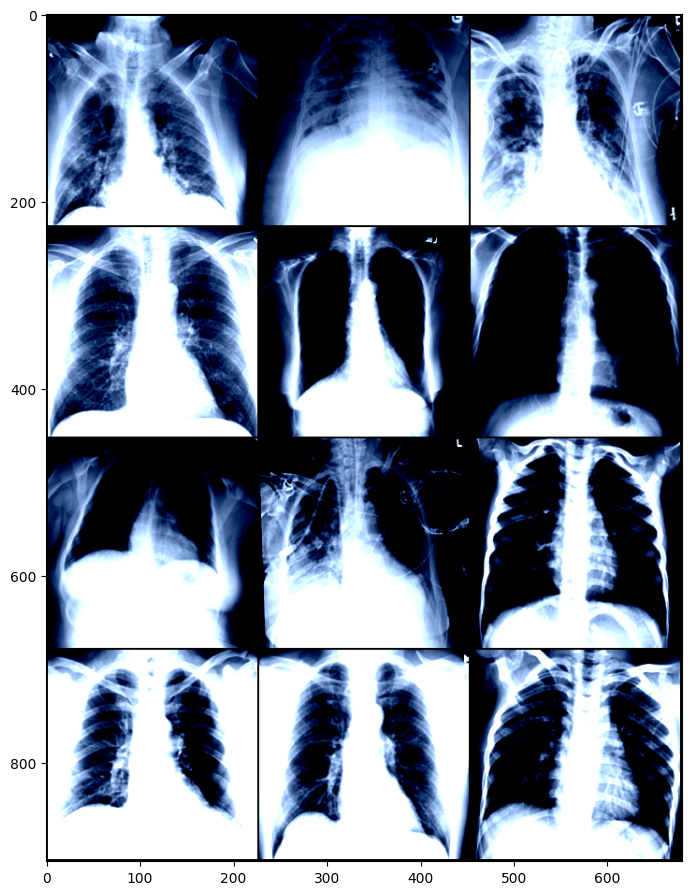

In [8]:
show_transformed_images(train_data)

In [9]:
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []

callback = TrainingMonitorCallback(
    model=model,
    optimizer=optimizer,
    patience=5,
    stop_patience=3,
    accuracy_threshold=0.9,
    learning_rate_factor=0.1,
    total_epochs=NUM_EPOCHS,
)

callback.on_train_begin()

for epoch in range(NUM_EPOCHS):
    callback.on_epoch_begin()

    # Training
    model.train()
    train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predictions = torch.max(outputs, 1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

    train_accuracy = (correct_predictions / total_predictions) * 100
    train_loss /= total_predictions
    train_acc_history.append(train_accuracy)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs, 1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

    val_accuracy = (correct_predictions / total_predictions) * 100
    val_loss /= total_predictions
    val_acc_history.append(val_accuracy)
    val_loss_history.append(val_loss)

    # Checkpoint and early stopping
    stop_training = callback.on_epoch_end(
        epoch, train_accuracy, train_loss, val_accuracy, val_loss
    )
    if stop_training:
        break

callback.on_train_end()


Would you like to be prompted to halt training? (y/n):  y



 Epoch   |    Loss    | Accuracy  | Val Loss  |  Val Acc  |    LR     |   Monitor   | % Improvement | Duration (s)
------------------------------------------------------------------------------------------------------------------
   1     |   1.373    |   62.84   |  0.87424  |   75.90   |  0.00100  | Validation Loss |    nan     |  200.73 
   2     |   0.880    |   73.95   |  2.32560  |   79.25   |  0.00100  | Validation Loss |  -145.14   |  150.09 
   3     |   0.671    |   78.34   |  0.67062  |   84.40   |  0.00100  | Validation Loss |   20.36    |  150.85 
   4     |   0.562    |   81.62   |  0.47400  |   85.40   |  0.00100  | Validation Loss |   19.66    |  150.41 
   5     |   0.503    |   82.77   |  0.60368  |   86.29   |  0.00100  | Validation Loss |   -12.97   |  149.48 
   6     |   0.441    |   84.66   |  0.35179  |   87.85   |  0.00100  | Validation Loss |   12.22    |  150.46 
   7     |   0.404    |   86.20   |  0.34902  |   87.52   |  0.00100  | Validation Loss |    0.28

 h



Training halted by user at epoch 10.

Training completed in 0 hours, 25 minutes, 56.23 seconds


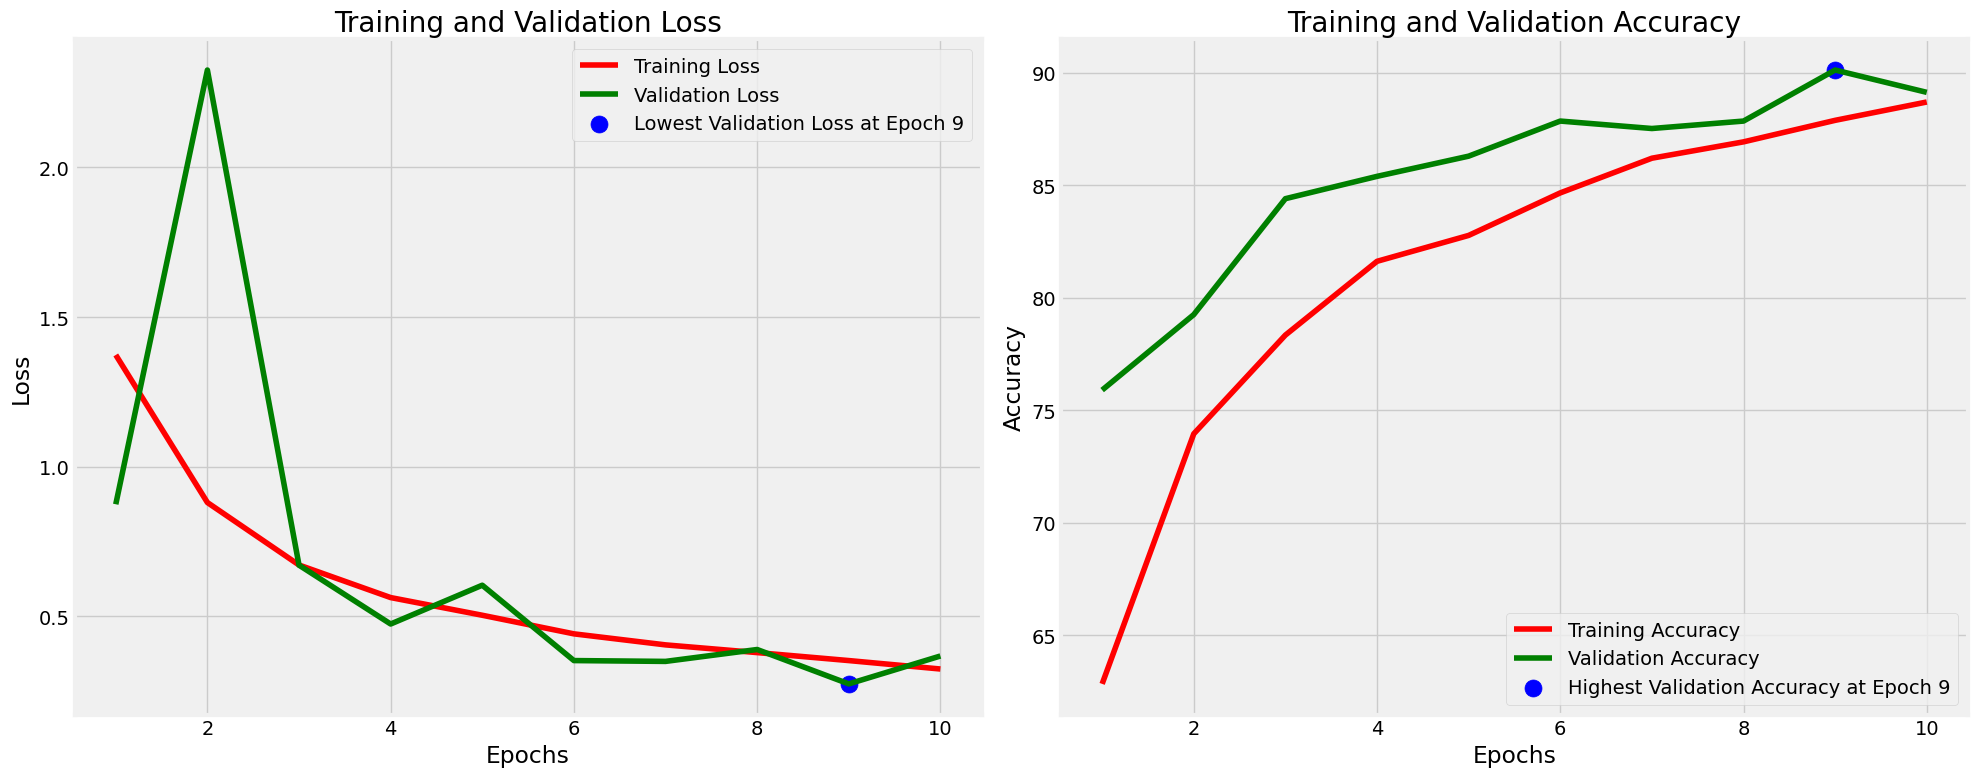

In [10]:
plot_training_history(
    train_acc_history, train_loss_history, val_acc_history, val_loss_history
)


## Model Evaluation:

- The model evaluation begins by setting the model to evaluation mode using `model.eval()`. This ensures that layers like dropout or batch normalization are in inference mode, which is important for obtaining correct results during evaluation.

- The evaluation loop iterates over the test loader, which provides batches of test images and their corresponding labels.

- After evaluating all test batches, the overall test accuracy is calculated by dividing the total correct predictions by the total number of test images.

- Next, the confusion matrix is computed using the `confusion_matrix` function from scikit-learn. The confusion matrix provides insights into the model's performance by showing the number of correct and incorrect predictions for each class.

- Additionally, metrics such as precision, recall, and F1-score are computed using scikit-learn's functions to provide more detailed evaluation results.

In [11]:
model.eval()

y_true = []
y_pred = []

for images, labels in test_loader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())

final_test_accuracy = (np.array(y_true) == np.array(y_pred)).mean() * 100
print(f"Accuracy on Test Data with {len(y_true)} images: {final_test_accuracy:.2f}%")


Accuracy on Test Data with 2117 images: 87.44%


Normalized confusion matrix


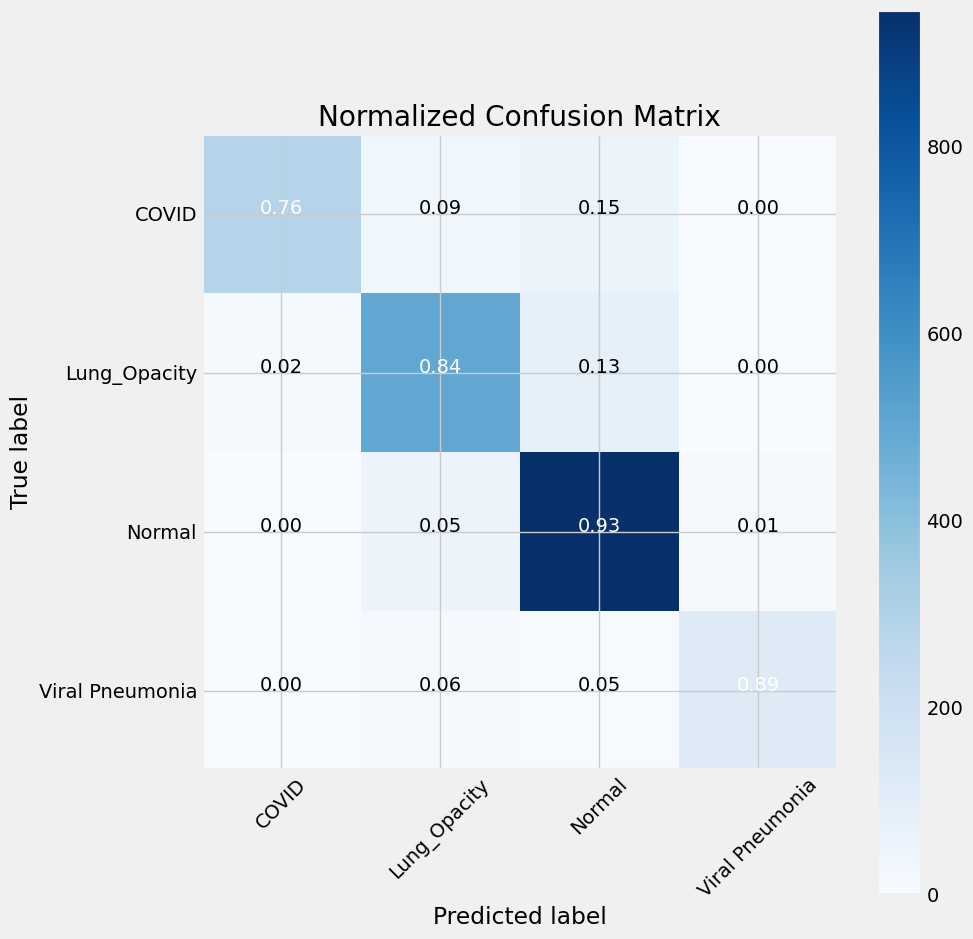

In [12]:
cm = confusion_matrix(y_true, y_pred)
class_names = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
plot_confusion_matrix(
    cm, class_names, normalize=True, title="Normalized Confusion Matrix"
)


In [13]:
print(f"Accuracy on Test Data: {final_test_accuracy:.2f}%")
print(f"Precision on Test Data: {precision_score(y_true, y_pred, average='micro'):.2f}")
print(f"Recall on Test Data: {recall_score(y_true, y_pred, average='micro'):.2f}")
print(f"F1-Score on Test Data: {f1_score(y_true, y_pred, average='micro'):.2f}")


Accuracy on Test Data: 87.44%
Precision on Test Data: 0.87
Recall on Test Data: 0.87
F1-Score on Test Data: 0.87


In [15]:
accuracies_df = pd.DataFrame(
    {
        "Epochs": list(range(1, NUM_EPOCHS + 1)),
        "Training Accuracy": train_acc_history,
        "Validation Accuracy": val_acc_history,
    }
)
accuracies_df.to_csv("./accuracies_4_classes_EfficientNetB0.csv", sep=",", index=False)

losses_df = pd.DataFrame(
    {
        "Epochs": list(range(1, NUM_EPOCHS + 1)),
        "Training Loss": train_loss_history,
        "Validation Loss": val_loss_history,
    }
)
losses_df.to_csv("./losses_4_classes_EfficientNetB0.csv", sep=",", index=False)

y_values_df = pd.DataFrame({"Y_true": y_true, "Y_pred": y_pred})
y_values_df.to_csv("./Y_values_4_classes_EfficientNetB0.csv", sep=",", index=False)
